Модель сохранена в xgboost_model.pkl
Метрики качества модели:
R2: 0.91
MSE: 12020590.00
MAE: 2626.87
RMSE: 3467.07


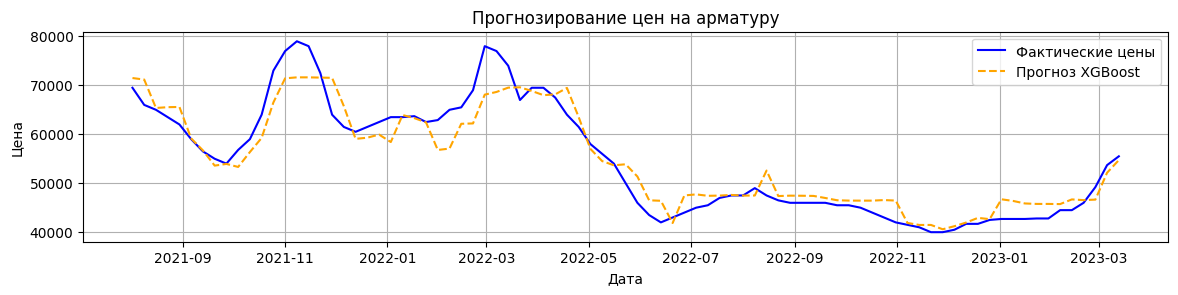

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import joblib
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Загрузка данных
df = pd.read_csv('combined.csv', parse_dates=['dt'])
df = df.rename(columns={'Цена на арматуру': 'price'})

# Проверка наличия необходимых колонок
assert 'price' in df.columns, "Колонка с ценой не найдена"
assert 'dt' in df.columns, "Колонка с датой не найдена"

# Создание временных признаков
def create_features(df):
    df = df.copy()
    df['year'] = df['dt'].dt.year
    df['month'] = df['dt'].dt.month
    df['week_of_year'] = df['dt'].dt.isocalendar().week
    
    for lag in range(1, 7):
        df[f'price_lag_{lag}'] = df['price'].shift(lag)
    
    df['rolling_mean_4'] = df['price'].rolling(4).mean().shift(1)
    df['rolling_std_4'] = df['price'].rolling(4).std().shift(1)
    return df

df = create_features(df).dropna()

# Разделение данных на обучающую и тестовую выборки
train_size = int(len(df) * 0.8)
train = df.iloc[:train_size]
test = df.iloc[train_size:]

X_train = train.drop(['dt', 'price'], axis=1)
y_train = train['price']
X_test = test.drop(['dt', 'price'], axis=1)
y_test = test['price']

# Обучение модели
model = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    early_stopping_rounds=50,
    random_state=42
)

model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

# Сохранение модели
joblib.dump(model, "xgboost_model.pkl")
print("Модель сохранена в xgboost_model.pkl")

# Прогнозирование
y_pred = model.predict(X_test)

# Метрики качества
metrics = {
    'R2': r2_score(y_test, y_pred),
    'MSE': mean_squared_error(y_test, y_pred),
    'MAE': mean_absolute_error(y_test, y_pred),
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred))
}

print("Метрики качества модели:")
for k, v in metrics.items():
    print(f"{k}: {v:.2f}")

# Визуализация прогнозов
plt.figure(figsize=(14, 6))

# График фактических и предсказанных цен
plt.subplot(2, 1, 1)
plt.plot(test['dt'], y_test, label='Фактические цены', color='blue')
plt.plot(test['dt'], y_pred, label='Прогноз XGBoost', linestyle='--', color='orange')
plt.title('Прогнозирование цен на арматуру')
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.legend()
plt.grid(True)

# Определение оптимального N недель закупки
def calculate_optimal_N(current_price, predictions):
    savings = []
    for N in range(1, 7):  # Проверяем от 1 до 6 недель
        predicted_total = sum(predictions[:N])  # Сумма предсказанных цен на N недель
        fixed_total = current_price * N  # Общая стоимость при фиксированной цене
        savings.append(fixed_total - predicted_total)  # Сохранение разницы
    return np.argmax(savings) + 1  # Возвращаем N, которое дает максимальную экономию

